<h1>ICASSP2019 Tutorial:<br> Detection and Classification of Acoustic Scenes and Events</h1>

Author: **Toni Heittola**

<a href="http://arg.cs.tut.fi/" target="_blank"><em>Audio Research Group / Tampere University</em></a><br>
<a href="mailto:toni.heittola@tuni.fi" target="_blank">[Email]</a>
<a href="http://www.cs.tut.fi/~heittolt/" target="_blank">[Homepage]</a>
<a href="https://github.com/toni-heittola" target="_blank">[Github]</a>

<h1 class="text-muted">Sound classification with Python</h1>

This notebook demonstrates basic steps needed to build **CNN** based system.

**Acoustic scene classification** is used as an example application

Key tools used in this example:

- **`dcase_util`** &ndash; used to ease data handling
- **`keras`** &ndash; neural network API for fast experimentation used on top of **`tensorflow`** machine learning framework
- **`scikit-learn`** &ndash; set of machine learning tools, here used to evaluate the system output


Jupyter notebook: 
https://github.com/toni-heittola/icassp2019-tutorial

In [27]:
import dcase_util
from dcase_util.containers import AudioContainer
from dcase_util.features import MelExtractor
from dcase_util.data import ProbabilityEncoder
import os, numpy
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

# Handy tool to print data in HTML form
log = dcase_util.ui.FancyHTMLPrinter()

# Paths to store data
data_storage_path = 'data'
dataset_storage_path = os.path.join(data_storage_path, 'datasets')
feature_storage_path = os.path.join(data_storage_path, 'features_asc')
dcase_util.utils.Path().create(
    [data_storage_path, dataset_storage_path, feature_storage_path]
)

# Filename for acoustic model
model_filename = os.path.join(data_storage_path, 'model_asc.h5')  

def get_feature_filename(audio_filename, feature_storage_path):
    """Get feature filename from audio filename. """
    
    return dcase_util.utils.Path(path=audio_filename).modify(
        path_base=feature_storage_path, 
        filename_extension='.npy'
    )
    
def get_feature_matrix(audio_filename, feature_storage_path=os.path.join('data', 'features_asc')):    
    """Extract acoustic features (log mel-energies) for given audio file and store them."""
    
    feature_filename = get_feature_filename(audio_filename, feature_storage_path)
    if os.path.exists(feature_filename):
        return numpy.load(feature_filename)
    else:
        audio = dcase_util.containers.AudioContainer().load(filename=audio_filename,mono=True)
        mel_extractor = dcase_util.features.MelExtractor(n_mels=40, win_length_seconds=0.04, hop_length_seconds=0.02, fs=audio.fs)
        mel_data = mel_extractor.extract(y=audio)
        numpy.save(feature_filename, mel_data)
        return mel_data
    
# Setup Keras to use tensorflow as backend
dcase_util.keras.setup_keras(backend='tensorflow')
import keras
from keras.layers import *
from keras.models import Model

# Outline

- Key Python tools used in this example
- Dataset
- Cross-validation set
- Acoustic features
- Learning stage
- Testing stage
- Evaluation

# Dataset

**`dcase_util`** implements dataset handling classes which can be used to access diffently organized dataset through uniform API:

- Download the dataset from the origin, e.g. zenodo.org
- Extract downloaded zip-packages and check data integrity 
- Access meta data (e.g. filter data based on scene labels)
- Access cross-validation sets bundled with the dataset

**TUT Urban Acoustic Scenes 2018** development dataset is used in this example:
- Recordings from 10 scene classes, 6 large european cities
- 5-6 minute recordings around selected locations, which were split into **10 seconds audio segments**

Dataset can be downloaded and accessed easily by using **dataset handler class** from `dcase_util`:

In [4]:
db = dcase_util.datasets.TUTUrbanAcousticScenes_2018_DevelopmentSet(
    data_path=dataset_storage_path
).initialize()

In [5]:
print('Audio file count :', len(db.audio_files))
print('Scene class count:', len(db.scene_labels()))

Audio file count : 8640
Scene class count: 10


In [6]:
db.scene_labels()

['airport',
 'bus',
 'metro',
 'metro_station',
 'park',
 'public_square',
 'shopping_mall',
 'street_pedestrian',
 'street_traffic',
 'tram']

Basic statistics of the dataset:

In [8]:
db.meta.show(mode='print')

MetaDataContainer :: Class
Items                               : 8640 
Unique
  Files                             : 8640 
  Scene labels                      : 10 
  Event labels                      : 0 
  Tags                              : 0 
  Identifiers                       : 286 
  Source labels                     : 1 

Scene statistics
  Scene label             Count   Identifiers   
  --------------------   ------   -----------   
  airport                   864            22   
  bus                       864            36   
  metro                     864            29   
  metro_station             864            40   
  park                      864            25   
  public_square             864            24   
  shopping_mall             864            22   
  street_pedestrian         864            28   
  street_traffic            864            25   
  tram                      864            35   




*Identifiers* are unique recording locations

In [12]:
# Single item
db.meta[3080]['identifier']

'barcelona-107'

In [13]:
# Identifiers for items with bus scene label
db.meta.filter(scene_label='street_traffic').unique_identifiers[0:6]

['barcelona-161',
 'barcelona-162',
 'barcelona-163',
 'barcelona-268',
 'helsinki-164',
 'helsinki-165']

## Important information about the dataset

- We need to be aware of recording location of each segment 
- Audio segments from the same location around the same time are **highly correlated**    
- Unrealistic to be able to train the system and test it with material recorded in same location only a few minutes apart
- Cross-validation set should take this into account in order to give realistic performance estimates

# Cross-validation set

- Dataset is released with a single **train/test**-split
- We need also a **validation set** to follow system performance on **unseen data**
- Dataset class can be used to split original training set into a new training set and validation set (70/30 split done according to recording locations):

### Train/Test split bundled with the dataset

In [4]:
train_items = db.train(1).stats()['scenes']['count']
train_items = numpy.append(train_items, numpy.sum(train_items))
train_ids = db.train(1).stats()['scenes']['identifiers']
train_ids = numpy.append(train_ids, numpy.sum(train_ids))

test_items = db.eval(1).stats()['scenes']['count']
test_items = numpy.append(test_items, numpy.sum(test_items))
test_ids = db.eval(1).stats()['scenes']['identifiers']
test_ids = numpy.append(test_ids, numpy.sum(test_ids))
labels = db.scene_labels() 
labels.append('Overall')

log.table(
    cell_data=[
        labels, 
        train_items,         
        test_items,        
        train_items / (train_items + test_items) * 100.0,
        train_ids, 
        test_ids, 
        #train_ids / ( train_ids + test_ids)* 100.0,
    ],
    column_headers=['Scene label', 'Train set (items)', 'Test set (items)', 'Split percentage', 'Train (locations)', 'Test (locations)'],
    column_types=['str18', 'int', 'int', 'int', 'int', 'int', 'int'],
    column_separators=[0,3],
    row_separators=[10],
    scaling=100
)

Scene label,Train set (items),Test set (items),Split percentage,Train (locations),Test (locations)
airport,599,265,69,15,7
bus,622,242,71,26,10
metro,603,261,69,20,9
metro_station,605,259,70,28,12
park,622,242,71,18,7
public_square,648,216,75,18,6
shopping_mall,585,279,67,16,6
street_pedestrian,617,247,71,20,8
street_traffic,618,246,71,18,7
tram,603,261,69,24,11


### Generating validation set

- During the training we need a **validation set** to follow system performance on **unseen data**
- Validation set can be extracted from the training set while taking location identifiers into account
- Dataset class can be used to generate validation set and a new training set:

In [14]:
training_files, validation_files = db.validation_split(
    validation_amount=0.3,                           # split target 30% 
    fold=1,   
    balancing_mode='identifier_two_level_hierarchy', # balance scene and locations
    disable_progress_bar=True
)

train_meta = db.train(1).filter(file_list=training_files)
validation_meta = db.train(1).filter(file_list=validation_files)


In [15]:
print('Training items  ', len(training_files))
print('Validation items', len(validation_files))

Training items   4134
Validation items 1988



### Train / Validation statistics

In [16]:
train_items = train_meta.stats()['scenes']['count']
train_items = numpy.append(train_items, numpy.sum(train_items))
train_ids = train_meta.stats()['scenes']['identifiers']
train_ids = numpy.append(train_ids, numpy.sum(train_ids))

validation_items = validation_meta.stats()['scenes']['count']
validation_items = numpy.append(validation_items, numpy.sum(validation_items))
validation_ids = validation_meta.stats()['scenes']['identifiers']
validation_ids = numpy.append(validation_ids, numpy.sum(validation_ids))

test_items = db.eval(1).stats()['scenes']['count']
test_items = numpy.append(test_items, numpy.sum(test_items))
test_ids = db.eval(1).stats()['scenes']['identifiers']
test_ids = numpy.append(test_ids, numpy.sum(test_ids))
labels = db.scene_labels() 
labels.append('Overall')

log.table(
    cell_data=[
        labels, 
        train_ids, 
        validation_ids, 
        validation_ids / ( train_ids + validation_ids)* 100.0,
        #test_ids,         

        train_items,         
        validation_items,  
        validation_items / (train_items + validation_items) * 100.0,
        #test_items,        

    ],
    column_headers=['Scene label', 
                    'Train (locations)', 'Validation (locations)', 'Split percentage', 
                    #'Test (locations)',
                    'Train set (items)', 'Validation set (items)', 'Split percentage', 
                    #'Test set (items)',
                   
                   ],
    column_types=['str17', 'int', 'int', 'float1', 'int', 'int', 'float1', 'int'],
    column_separators=[0,3],
    row_separators=[10],
    scaling=110
)

Scene label,Train (locations),Validation (locations),Split percentage,Train set (items),Validation set (items),Split percentage
airport,9,6,40.0,411,188,31.4
bus,16,10,38.5,413,209,33.6
metro,13,7,35.0,422,181,30.0
metro_station,18,10,35.7,408,197,32.6
park,12,6,33.3,425,197,31.7
public_square,12,6,33.3,433,215,33.2
shopping_mall,10,6,37.5,360,225,38.5
street_pedestrian,13,7,35.0,422,195,31.6
street_traffic,12,6,33.3,425,193,31.2
tram,16,8,33.3,415,188,31.2


# Acoustic features - log-mel energies

Feature extractor initialized with parameters and used to extract features:

In [17]:
audio = dcase_util.containers.AudioContainer().load(
    filename=db.audio_files[0], 
    mono=True
)
mel_extractor = dcase_util.features.MelExtractor(
    n_mels=40, 
    win_length_seconds=0.04, 
    hop_length_seconds=0.02, 
    fs=audio.fs
)
mel_data = mel_extractor.extract(
    y=audio
)

In [18]:
print('mel_data shape', '(frequency, time)', mel_data.shape)

mel_data shape (frequency, time) (40, 501)


# Learning acoustic model

For each learning example, we need to have:

1) **Feature matrix**

In [19]:
# Load audio
audio = dcase_util.containers.AudioContainer().load(
    filename=train_meta[0].filename, mono=True
)

# Extract log-mel energies
sequence_length = 500        # 10s / 0.02s = 500
mel_extractor = dcase_util.features.MelExtractor(
    n_mels=40, win_length_seconds=0.04, hop_length_seconds=0.02, fs=audio.fs
)
features = mel_extractor.extract(audio.data)[:,:sequence_length]

In [20]:
print('features shape', '(frequency, time)', features.shape)

features shape (frequency, time) (40, 500)


### Feature matrix visualized

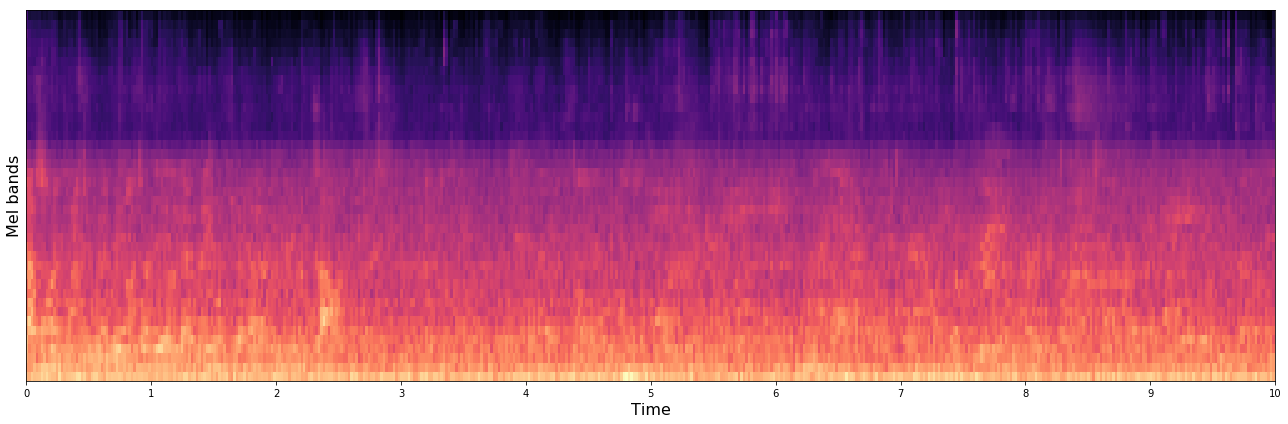

In [21]:
dcase_util.containers.FeatureContainer(
    data=features,
    time_resolution=mel_extractor.hop_length_seconds
).plot(
    ylabel='Mel bands',
    xlabel='Time',
    figsize=(18,6)
)

2) **Target vector** (one-hot encoded vector)

In [22]:
# List of scene labels
scene_labels = db.scene_labels()               

# Empty target vector
target_vector = numpy.zeros(len(scene_labels))      

# Place one at correct position 
target_vector[scene_labels.index(train_meta[0].scene_label)] = 1   
target_vector 

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
print('target vector shape', '(classes, )', target_vector.shape)

target vector shape (classes, ) (10,)


## Collect training data

In [24]:
X_train = []
Y_train = []
for item in train_meta:
    print('Load', db.absolute_to_relative_path(item.filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    features = get_feature_matrix(item.filename, feature_storage_path)[:,:sequence_length]
    
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    target_vector = numpy.zeros(len(scene_labels))
    target_vector[scene_labels.index(item.scene_label)] = 1
    
    X_train.append(features) 
    Y_train.append(target_vector)
    
X_train = numpy.moveaxis(numpy.dstack(X_train), 2, 0)
Y_train = numpy.vstack(Y_train)
print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)

Load audio/airport-barcelona-1-16-a.wav
Load audio/airport-barcelona-1-17-a.wav
Load audio/airport-barcelona-1-18-a.wav
Load audio/airport-barcelona-1-19-a.wav
Load audio/airport-barcelona-1-20-a.wav
Load audio/airport-barcelona-1-21-a.wav
Load audio/airport-barcelona-1-22-a.wav
Load audio/airport-barcelona-1-23-a.wav
Load audio/airport-barcelona-1-24-a.wav
Load audio/airport-barcelona-1-25-a.wav
Load audio/airport-barcelona-1-26-a.wav
Load audio/airport-barcelona-1-27-a.wav
Load audio/airport-barcelona-1-28-a.wav
Load audio/airport-barcelona-1-29-a.wav
Load audio/airport-barcelona-1-30-a.wav
Load audio/airport-barcelona-1-31-a.wav
Load audio/airport-barcelona-1-32-a.wav
Load audio/airport-barcelona-1-33-a.wav
Load audio/airport-barcelona-1-34-a.wav
Load audio/airport-barcelona-1-35-a.wav
Load audio/airport-barcelona-1-36-a.wav
Load audio/airport-barcelona-1-37-a.wav
Load audio/airport-barcelona-1-38-a.wav
Load audio/airport-barcelona-1-39-a.wav
Load audio/airport-barcelona-1-40-a.wav


Load audio/airport-paris-7-312-a.wav
Load audio/airport-paris-7-313-a.wav
Load audio/airport-paris-7-314-a.wav
Load audio/airport-paris-7-315-a.wav
Load audio/airport-paris-7-316-a.wav
Load audio/airport-paris-7-317-a.wav
Load audio/airport-paris-7-318-a.wav
Load audio/airport-paris-7-319-a.wav
Load audio/airport-paris-7-320-a.wav
Load audio/airport-paris-7-321-a.wav
Load audio/airport-paris-7-322-a.wav
Load audio/airport-paris-7-323-a.wav
Load audio/airport-paris-7-324-a.wav
Load audio/airport-paris-7-325-a.wav
Load audio/airport-paris-7-326-a.wav
Load audio/airport-paris-7-327-a.wav
Load audio/airport-paris-7-328-a.wav
Load audio/airport-paris-7-329-a.wav
Load audio/airport-paris-7-330-a.wav
Load audio/airport-paris-7-331-a.wav
Load audio/airport-paris-7-332-a.wav
Load audio/airport-paris-7-333-a.wav
Load audio/airport-paris-7-334-a.wav
Load audio/airport-paris-7-335-a.wav
Load audio/airport-paris-7-336-a.wav
Load audio/airport-paris-7-337-a.wav
Load audio/airport-paris-7-338-a.wav
L

Load audio/bus-barcelona-16-642-a.wav
Load audio/bus-barcelona-16-643-a.wav
Load audio/bus-barcelona-16-644-a.wav
Load audio/bus-barcelona-16-645-a.wav
Load audio/bus-barcelona-16-646-a.wav
Load audio/bus-barcelona-16-647-a.wav
Load audio/bus-barcelona-16-648-a.wav
Load audio/bus-barcelona-16-649-a.wav
Load audio/bus-barcelona-16-650-a.wav
Load audio/bus-barcelona-16-651-a.wav
Load audio/bus-barcelona-16-652-a.wav
Load audio/bus-barcelona-16-653-a.wav
Load audio/bus-barcelona-16-654-a.wav
Load audio/bus-barcelona-16-655-a.wav
Load audio/bus-barcelona-16-656-a.wav
Load audio/bus-barcelona-16-657-a.wav
Load audio/bus-barcelona-16-658-a.wav
Load audio/bus-barcelona-16-659-a.wav
Load audio/bus-barcelona-16-660-a.wav
Load audio/bus-barcelona-16-661-a.wav
Load audio/bus-barcelona-16-662-a.wav
Load audio/bus-barcelona-16-663-a.wav
Load audio/bus-barcelona-16-664-a.wav
Load audio/bus-barcelona-16-665-a.wav
Load audio/bus-barcelona-16-666-a.wav
Load audio/bus-barcelona-16-667-a.wav
Load audio/b

Load audio/bus-paris-26-918-a.wav
Load audio/bus-paris-26-919-a.wav
Load audio/bus-paris-26-920-a.wav
Load audio/bus-paris-26-921-a.wav
Load audio/bus-paris-26-922-a.wav
Load audio/bus-paris-26-923-a.wav
Load audio/bus-paris-26-924-a.wav
Load audio/bus-paris-27-925-a.wav
Load audio/bus-paris-27-926-a.wav
Load audio/bus-paris-27-927-a.wav
Load audio/bus-paris-27-928-a.wav
Load audio/bus-paris-27-929-a.wav
Load audio/bus-paris-27-930-a.wav
Load audio/bus-paris-27-931-a.wav
Load audio/bus-paris-27-932-a.wav
Load audio/bus-paris-27-933-a.wav
Load audio/bus-paris-27-934-a.wav
Load audio/bus-paris-27-935-a.wav
Load audio/bus-paris-27-936-a.wav
Load audio/bus-paris-27-937-a.wav
Load audio/bus-paris-27-938-a.wav
Load audio/bus-paris-28-939-a.wav
Load audio/bus-paris-28-940-a.wav
Load audio/bus-paris-28-941-a.wav
Load audio/bus-paris-28-942-a.wav
Load audio/bus-paris-28-943-a.wav
Load audio/bus-paris-28-944-a.wav
Load audio/bus-paris-28-945-a.wav
Load audio/bus-paris-28-946-a.wav
Load audio/bus

Load audio/metro-helsinki-44-1322-a.wav
Load audio/metro-helsinki-44-1323-a.wav
Load audio/metro-helsinki-44-1324-a.wav
Load audio/metro-helsinki-44-1325-a.wav
Load audio/metro-helsinki-44-1326-a.wav
Load audio/metro-helsinki-44-1327-a.wav
Load audio/metro-helsinki-44-1328-a.wav
Load audio/metro-helsinki-44-1329-a.wav
Load audio/metro-helsinki-44-1330-a.wav
Load audio/metro-helsinki-44-1331-a.wav
Load audio/metro-helsinki-45-1332-a.wav
Load audio/metro-helsinki-45-1333-a.wav
Load audio/metro-helsinki-45-1334-a.wav
Load audio/metro-helsinki-45-1335-a.wav
Load audio/metro-helsinki-45-1336-a.wav
Load audio/metro-helsinki-45-1337-a.wav
Load audio/metro-helsinki-45-1338-a.wav
Load audio/metro-helsinki-45-1339-a.wav
Load audio/metro-helsinki-45-1340-a.wav
Load audio/metro-helsinki-45-1341-a.wav
Load audio/metro-helsinki-45-1342-a.wav
Load audio/metro-helsinki-45-1343-a.wav
Load audio/metro-helsinki-45-1344-a.wav
Load audio/metro-helsinki-45-1345-a.wav
Load audio/metro-helsinki-45-1346-a.wav


Load audio/metro-paris-54-1586-a.wav
Load audio/metro-paris-54-1587-a.wav
Load audio/metro-paris-54-1588-a.wav
Load audio/metro-paris-54-1589-a.wav
Load audio/metro-paris-54-1590-a.wav
Load audio/metro-paris-54-1591-a.wav
Load audio/metro-paris-54-1592-a.wav
Load audio/metro-paris-54-1593-a.wav
Load audio/metro-paris-54-1594-a.wav
Load audio/metro-paris-54-1595-a.wav
Load audio/metro-paris-54-1596-a.wav
Load audio/metro-paris-54-1597-a.wav
Load audio/metro-paris-54-1598-a.wav
Load audio/metro-paris-54-1599-a.wav
Load audio/metro-paris-54-1600-a.wav
Load audio/metro-paris-54-1601-a.wav
Load audio/metro-paris-54-1602-a.wav
Load audio/metro-paris-54-1603-a.wav
Load audio/metro-paris-54-1604-a.wav
Load audio/metro-paris-54-1605-a.wav
Load audio/metro-paris-54-1606-a.wav
Load audio/metro-stockholm-56-1644-a.wav
Load audio/metro-stockholm-56-1645-a.wav
Load audio/metro-stockholm-56-1646-a.wav
Load audio/metro-stockholm-56-1647-a.wav
Load audio/metro-stockholm-56-1648-a.wav
Load audio/metro-s

Load audio/metro_station-barcelona-62-1863-a.wav
Load audio/metro_station-barcelona-62-1864-a.wav
Load audio/metro_station-barcelona-62-1865-a.wav
Load audio/metro_station-barcelona-62-1866-a.wav
Load audio/metro_station-barcelona-62-1867-a.wav
Load audio/metro_station-barcelona-62-1868-a.wav
Load audio/metro_station-barcelona-62-1869-a.wav
Load audio/metro_station-barcelona-62-1870-a.wav
Load audio/metro_station-barcelona-62-1871-a.wav
Load audio/metro_station-barcelona-62-1872-a.wav
Load audio/metro_station-barcelona-62-1873-a.wav
Load audio/metro_station-barcelona-62-1874-a.wav
Load audio/metro_station-barcelona-62-1875-a.wav
Load audio/metro_station-barcelona-62-1876-a.wav
Load audio/metro_station-barcelona-62-1877-a.wav
Load audio/metro_station-barcelona-62-1878-a.wav
Load audio/metro_station-barcelona-62-1879-a.wav
Load audio/metro_station-barcelona-62-1880-a.wav
Load audio/metro_station-helsinki-65-1940-a.wav
Load audio/metro_station-helsinki-65-1941-a.wav
Load audio/metro_stati

Load audio/metro_station-paris-80-2166-a.wav
Load audio/metro_station-paris-80-2167-a.wav
Load audio/metro_station-paris-80-2168-a.wav
Load audio/metro_station-paris-80-2169-a.wav
Load audio/metro_station-paris-80-2170-a.wav
Load audio/metro_station-paris-80-2171-a.wav
Load audio/metro_station-paris-80-2172-a.wav
Load audio/metro_station-paris-80-2173-a.wav
Load audio/metro_station-paris-80-2174-a.wav
Load audio/metro_station-paris-80-2175-a.wav
Load audio/metro_station-paris-80-2176-a.wav
Load audio/metro_station-paris-80-2177-a.wav
Load audio/metro_station-paris-80-2178-a.wav
Load audio/metro_station-paris-80-2179-a.wav
Load audio/metro_station-paris-80-2180-a.wav
Load audio/metro_station-paris-81-2181-a.wav
Load audio/metro_station-paris-81-2182-a.wav
Load audio/metro_station-paris-81-2183-a.wav
Load audio/metro_station-paris-81-2184-a.wav
Load audio/metro_station-paris-81-2185-a.wav
Load audio/metro_station-paris-81-2186-a.wav
Load audio/metro_station-paris-81-2187-a.wav
Load audio

Load audio/metro_station-vienna-88-2417-a.wav
Load audio/metro_station-vienna-88-2418-a.wav
Load audio/metro_station-vienna-88-2419-a.wav
Load audio/metro_station-vienna-88-2420-a.wav
Load audio/metro_station-vienna-88-2421-a.wav
Load audio/metro_station-vienna-88-2422-a.wav
Load audio/metro_station-vienna-88-2423-a.wav
Load audio/metro_station-vienna-88-2424-a.wav
Load audio/metro_station-vienna-88-2425-a.wav
Load audio/metro_station-vienna-88-2426-a.wav
Load audio/metro_station-vienna-88-2427-a.wav
Load audio/metro_station-vienna-88-2428-a.wav
Load audio/park-barcelona-89-2429-a.wav
Load audio/park-barcelona-89-2430-a.wav
Load audio/park-barcelona-89-2431-a.wav
Load audio/park-barcelona-89-2432-a.wav
Load audio/park-barcelona-89-2433-a.wav
Load audio/park-barcelona-89-2434-a.wav
Load audio/park-barcelona-89-2435-a.wav
Load audio/park-barcelona-89-2436-a.wav
Load audio/park-barcelona-89-2437-a.wav
Load audio/park-barcelona-89-2438-a.wav
Load audio/park-barcelona-89-2439-a.wav
Load aud

Load audio/park-london-96-2687-a.wav
Load audio/park-london-96-2688-a.wav
Load audio/park-london-96-2689-a.wav
Load audio/park-london-96-2690-a.wav
Load audio/park-london-96-2691-a.wav
Load audio/park-london-96-2692-a.wav
Load audio/park-london-96-2693-a.wav
Load audio/park-london-96-2694-a.wav
Load audio/park-london-96-2695-a.wav
Load audio/park-london-96-2696-a.wav
Load audio/park-london-96-2697-a.wav
Load audio/park-london-96-2698-a.wav
Load audio/park-london-96-2699-a.wav
Load audio/park-london-96-2700-a.wav
Load audio/park-london-96-2701-a.wav
Load audio/park-london-96-2702-a.wav
Load audio/park-london-96-2703-a.wav
Load audio/park-london-96-2704-a.wav
Load audio/park-london-96-2705-a.wav
Load audio/park-london-96-2706-a.wav
Load audio/park-london-96-2707-a.wav
Load audio/park-london-96-2708-a.wav
Load audio/park-london-96-2709-a.wav
Load audio/park-london-96-2710-a.wav
Load audio/park-london-96-2711-a.wav
Load audio/park-paris-98-2748-a.wav
Load audio/park-paris-98-2749-a.wav
Loa

Load audio/park-vienna-106-3039-a.wav
Load audio/park-vienna-106-3040-a.wav
Load audio/park-vienna-106-3041-a.wav
Load audio/park-vienna-106-3042-a.wav
Load audio/park-vienna-106-3043-a.wav
Load audio/park-vienna-106-3044-a.wav
Load audio/park-vienna-106-3045-a.wav
Load audio/park-vienna-106-3046-a.wav
Load audio/park-vienna-106-3047-a.wav
Load audio/park-vienna-106-3048-a.wav
Load audio/park-vienna-106-3049-a.wav
Load audio/park-vienna-106-3050-a.wav
Load audio/public_square-barcelona-107-3051-a.wav
Load audio/public_square-barcelona-107-3052-a.wav
Load audio/public_square-barcelona-107-3053-a.wav
Load audio/public_square-barcelona-107-3054-a.wav
Load audio/public_square-barcelona-107-3055-a.wav
Load audio/public_square-barcelona-107-3056-a.wav
Load audio/public_square-barcelona-107-3057-a.wav
Load audio/public_square-barcelona-107-3058-a.wav
Load audio/public_square-barcelona-107-3059-a.wav
Load audio/public_square-barcelona-107-3060-a.wav
Load audio/public_square-barcelona-107-3061-

Load audio/public_square-london-113-3282-a.wav
Load audio/public_square-london-113-3283-a.wav
Load audio/public_square-london-113-3284-a.wav
Load audio/public_square-london-113-3285-a.wav
Load audio/public_square-london-113-3286-a.wav
Load audio/public_square-london-113-3287-a.wav
Load audio/public_square-london-113-3288-a.wav
Load audio/public_square-london-113-3289-a.wav
Load audio/public_square-london-113-3290-a.wav
Load audio/public_square-london-113-3291-a.wav
Load audio/public_square-london-113-3292-a.wav
Load audio/public_square-london-113-3293-a.wav
Load audio/public_square-london-113-3294-a.wav
Load audio/public_square-london-113-3295-a.wav
Load audio/public_square-london-113-3296-a.wav
Load audio/public_square-london-113-3297-a.wav
Load audio/public_square-london-113-3298-a.wav
Load audio/public_square-london-113-3299-a.wav
Load audio/public_square-london-113-3300-a.wav
Load audio/public_square-london-113-3301-a.wav
Load audio/public_square-london-113-3302-a.wav
Load audio/pu

Load audio/public_square-stockholm-121-3564-a.wav
Load audio/public_square-stockholm-121-3565-a.wav
Load audio/public_square-stockholm-121-3566-a.wav
Load audio/public_square-stockholm-121-3567-a.wav
Load audio/public_square-stockholm-121-3568-a.wav
Load audio/public_square-stockholm-121-3569-a.wav
Load audio/public_square-stockholm-121-3570-a.wav
Load audio/public_square-stockholm-121-3571-a.wav
Load audio/public_square-stockholm-121-3572-a.wav
Load audio/public_square-stockholm-121-3573-a.wav
Load audio/public_square-stockholm-121-3574-a.wav
Load audio/public_square-stockholm-121-3575-a.wav
Load audio/public_square-stockholm-121-3576-a.wav
Load audio/public_square-stockholm-121-3577-a.wav
Load audio/public_square-stockholm-121-3578-a.wav
Load audio/public_square-stockholm-121-3579-a.wav
Load audio/public_square-stockholm-121-3580-a.wav
Load audio/public_square-stockholm-121-3581-a.wav
Load audio/public_square-stockholm-121-3582-a.wav
Load audio/public_square-stockholm-121-3583-a.wav


Load audio/shopping_mall-helsinki-128-3808-a.wav
Load audio/shopping_mall-helsinki-128-3809-a.wav
Load audio/shopping_mall-helsinki-128-3810-a.wav
Load audio/shopping_mall-helsinki-128-3811-a.wav
Load audio/shopping_mall-helsinki-128-3812-a.wav
Load audio/shopping_mall-helsinki-128-3813-a.wav
Load audio/shopping_mall-helsinki-128-3814-a.wav
Load audio/shopping_mall-helsinki-128-3815-a.wav
Load audio/shopping_mall-helsinki-128-3816-a.wav
Load audio/shopping_mall-helsinki-128-3817-a.wav
Load audio/shopping_mall-helsinki-128-3818-a.wav
Load audio/shopping_mall-helsinki-128-3819-a.wav
Load audio/shopping_mall-helsinki-128-3820-a.wav
Load audio/shopping_mall-helsinki-128-3821-a.wav
Load audio/shopping_mall-helsinki-128-3822-a.wav
Load audio/shopping_mall-helsinki-128-3823-a.wav
Load audio/shopping_mall-helsinki-128-3824-a.wav
Load audio/shopping_mall-helsinki-128-3825-a.wav
Load audio/shopping_mall-helsinki-128-3826-a.wav
Load audio/shopping_mall-helsinki-128-3827-a.wav
Load audio/shopping_

Load audio/shopping_mall-stockholm-135-4097-a.wav
Load audio/shopping_mall-stockholm-135-4098-a.wav
Load audio/shopping_mall-stockholm-135-4099-a.wav
Load audio/shopping_mall-stockholm-135-4100-a.wav
Load audio/shopping_mall-stockholm-135-4101-a.wav
Load audio/shopping_mall-stockholm-135-4102-a.wav
Load audio/shopping_mall-stockholm-135-4103-a.wav
Load audio/shopping_mall-stockholm-136-4104-a.wav
Load audio/shopping_mall-stockholm-136-4105-a.wav
Load audio/shopping_mall-stockholm-136-4106-a.wav
Load audio/shopping_mall-stockholm-136-4107-a.wav
Load audio/shopping_mall-stockholm-136-4108-a.wav
Load audio/shopping_mall-stockholm-136-4109-a.wav
Load audio/shopping_mall-stockholm-136-4110-a.wav
Load audio/shopping_mall-stockholm-136-4111-a.wav
Load audio/shopping_mall-stockholm-136-4112-a.wav
Load audio/shopping_mall-stockholm-136-4113-a.wav
Load audio/shopping_mall-stockholm-136-4114-a.wav
Load audio/shopping_mall-stockholm-136-4115-a.wav
Load audio/shopping_mall-stockholm-136-4116-a.wav


Load audio/street_pedestrian-barcelona-144-4358-a.wav
Load audio/street_pedestrian-barcelona-144-4359-a.wav
Load audio/street_pedestrian-barcelona-144-4360-a.wav
Load audio/street_pedestrian-barcelona-144-4361-a.wav
Load audio/street_pedestrian-barcelona-144-4362-a.wav
Load audio/street_pedestrian-barcelona-144-4363-a.wav
Load audio/street_pedestrian-barcelona-144-4364-a.wav
Load audio/street_pedestrian-barcelona-144-4365-a.wav
Load audio/street_pedestrian-barcelona-144-4366-a.wav
Load audio/street_pedestrian-barcelona-144-4367-a.wav
Load audio/street_pedestrian-barcelona-144-4368-a.wav
Load audio/street_pedestrian-helsinki-146-4389-a.wav
Load audio/street_pedestrian-helsinki-146-4390-a.wav
Load audio/street_pedestrian-helsinki-146-4391-a.wav
Load audio/street_pedestrian-helsinki-146-4392-a.wav
Load audio/street_pedestrian-helsinki-146-4393-a.wav
Load audio/street_pedestrian-helsinki-146-4394-a.wav
Load audio/street_pedestrian-helsinki-146-4395-a.wav
Load audio/street_pedestrian-helsin

Load audio/street_pedestrian-paris-153-4620-a.wav
Load audio/street_pedestrian-paris-153-4621-a.wav
Load audio/street_pedestrian-paris-153-4622-a.wav
Load audio/street_pedestrian-paris-153-4623-a.wav
Load audio/street_pedestrian-paris-153-4624-a.wav
Load audio/street_pedestrian-paris-153-4625-a.wav
Load audio/street_pedestrian-paris-153-4626-a.wav
Load audio/street_pedestrian-paris-153-4627-a.wav
Load audio/street_pedestrian-paris-153-4628-a.wav
Load audio/street_pedestrian-paris-153-4629-a.wav
Load audio/street_pedestrian-paris-153-4630-a.wav
Load audio/street_pedestrian-paris-153-4631-a.wav
Load audio/street_pedestrian-paris-153-4632-a.wav
Load audio/street_pedestrian-paris-153-4633-a.wav
Load audio/street_pedestrian-paris-153-4634-a.wav
Load audio/street_pedestrian-paris-153-4635-a.wav
Load audio/street_pedestrian-paris-153-4636-a.wav
Load audio/street_pedestrian-paris-153-4637-a.wav
Load audio/street_pedestrian-paris-153-4638-a.wav
Load audio/street_pedestrian-paris-153-4639-a.wav


Load audio/street_pedestrian-vienna-158-4815-a.wav
Load audio/street_pedestrian-vienna-158-4816-a.wav
Load audio/street_pedestrian-vienna-158-4817-a.wav
Load audio/street_pedestrian-vienna-158-4818-a.wav
Load audio/street_pedestrian-vienna-158-4819-a.wav
Load audio/street_pedestrian-vienna-158-4820-a.wav
Load audio/street_pedestrian-vienna-158-4821-a.wav
Load audio/street_pedestrian-vienna-158-4822-a.wav
Load audio/street_pedestrian-vienna-158-4823-a.wav
Load audio/street_pedestrian-vienna-158-4824-a.wav
Load audio/street_pedestrian-vienna-158-4825-a.wav
Load audio/street_pedestrian-vienna-158-4826-a.wav
Load audio/street_pedestrian-vienna-158-4827-a.wav
Load audio/street_pedestrian-vienna-159-4828-a.wav
Load audio/street_pedestrian-vienna-159-4829-a.wav
Load audio/street_pedestrian-vienna-159-4830-a.wav
Load audio/street_pedestrian-vienna-159-4831-a.wav
Load audio/street_pedestrian-vienna-159-4832-a.wav
Load audio/street_pedestrian-vienna-159-4833-a.wav
Load audio/street_pedestrian-vi

Load audio/street_traffic-helsinki-166-5088-a.wav
Load audio/street_traffic-helsinki-166-5089-a.wav
Load audio/street_traffic-helsinki-166-5090-a.wav
Load audio/street_traffic-helsinki-166-5091-a.wav
Load audio/street_traffic-helsinki-166-5092-a.wav
Load audio/street_traffic-helsinki-166-5093-a.wav
Load audio/street_traffic-helsinki-166-5094-a.wav
Load audio/street_traffic-helsinki-166-5095-a.wav
Load audio/street_traffic-helsinki-166-5096-a.wav
Load audio/street_traffic-helsinki-166-5097-a.wav
Load audio/street_traffic-helsinki-166-5098-a.wav
Load audio/street_traffic-helsinki-166-5099-a.wav
Load audio/street_traffic-helsinki-166-5100-a.wav
Load audio/street_traffic-helsinki-166-5101-a.wav
Load audio/street_traffic-helsinki-166-5102-a.wav
Load audio/street_traffic-helsinki-166-5103-a.wav
Load audio/street_traffic-helsinki-166-5104-a.wav
Load audio/street_traffic-helsinki-166-5105-a.wav
Load audio/street_traffic-helsinki-166-5106-a.wav
Load audio/street_traffic-helsinki-166-5107-a.wav


Load audio/street_traffic-stockholm-173-5309-a.wav
Load audio/street_traffic-stockholm-173-5310-a.wav
Load audio/street_traffic-stockholm-173-5311-a.wav
Load audio/street_traffic-stockholm-173-5312-a.wav
Load audio/street_traffic-stockholm-173-5313-a.wav
Load audio/street_traffic-stockholm-173-5314-a.wav
Load audio/street_traffic-stockholm-173-5315-a.wav
Load audio/street_traffic-stockholm-173-5316-a.wav
Load audio/street_traffic-stockholm-173-5317-a.wav
Load audio/street_traffic-stockholm-173-5318-a.wav
Load audio/street_traffic-stockholm-173-5319-a.wav
Load audio/street_traffic-stockholm-173-5320-a.wav
Load audio/street_traffic-stockholm-173-5321-a.wav
Load audio/street_traffic-stockholm-173-5322-a.wav
Load audio/street_traffic-stockholm-173-5323-a.wav
Load audio/street_traffic-stockholm-173-5324-a.wav
Load audio/street_traffic-stockholm-173-5325-a.wav
Load audio/street_traffic-stockholm-173-5326-a.wav
Load audio/street_traffic-stockholm-173-5327-a.wav
Load audio/street_traffic-stock

Load audio/tram-barcelona-180-5592-a.wav
Load audio/tram-barcelona-180-5593-a.wav
Load audio/tram-barcelona-180-5594-a.wav
Load audio/tram-barcelona-180-5595-a.wav
Load audio/tram-barcelona-180-5596-a.wav
Load audio/tram-barcelona-180-5597-a.wav
Load audio/tram-barcelona-180-5598-a.wav
Load audio/tram-barcelona-181-5599-a.wav
Load audio/tram-barcelona-181-5600-a.wav
Load audio/tram-barcelona-181-5601-a.wav
Load audio/tram-barcelona-181-5602-a.wav
Load audio/tram-barcelona-181-5603-a.wav
Load audio/tram-barcelona-181-5604-a.wav
Load audio/tram-barcelona-181-5605-a.wav
Load audio/tram-barcelona-181-5606-a.wav
Load audio/tram-barcelona-181-5607-a.wav
Load audio/tram-barcelona-181-5608-a.wav
Load audio/tram-barcelona-181-5609-a.wav
Load audio/tram-barcelona-181-5610-a.wav
Load audio/tram-barcelona-181-5611-a.wav
Load audio/tram-barcelona-181-5612-a.wav
Load audio/tram-barcelona-181-5613-a.wav
Load audio/tram-barcelona-181-5614-a.wav
Load audio/tram-barcelona-181-5615-a.wav
Load audio/tram-

Load audio/tram-paris-194-5886-a.wav
Load audio/tram-paris-194-5887-a.wav
Load audio/tram-paris-194-5888-a.wav
Load audio/tram-paris-194-5889-a.wav
Load audio/tram-paris-195-5890-a.wav
Load audio/tram-paris-195-5891-a.wav
Load audio/tram-paris-195-5892-a.wav
Load audio/tram-paris-195-5893-a.wav
Load audio/tram-paris-195-5894-a.wav
Load audio/tram-paris-195-5895-a.wav
Load audio/tram-paris-195-5896-a.wav
Load audio/tram-paris-195-5897-a.wav
Load audio/tram-paris-195-5898-a.wav
Load audio/tram-paris-195-5899-a.wav
Load audio/tram-paris-195-5900-a.wav
Load audio/tram-paris-195-5901-a.wav
Load audio/tram-paris-195-5902-a.wav
Load audio/tram-paris-195-5903-a.wav
Load audio/tram-paris-195-5904-a.wav
Load audio/tram-paris-195-5905-a.wav
Load audio/tram-paris-195-5906-a.wav
Load audio/tram-paris-195-5907-a.wav
Load audio/tram-paris-195-5908-a.wav
Load audio/tram-paris-196-5909-a.wav
Load audio/tram-paris-196-5910-a.wav
Load audio/tram-paris-196-5911-a.wav
Load audio/tram-paris-196-5912-a.wav
L

## Collect validation data

Validation data is collected similar manner than training data:

In [25]:
X_validation = []
Y_validation = []
for item in validation_meta:
    print('Load', db.absolute_to_relative_path(item.filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    features = get_feature_matrix(item.filename, feature_storage_path)[:,:sequence_length]
    
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    target_vector = numpy.zeros(len(scene_labels))
    target_vector[scene_labels.index(item.scene_label)] = 1
    
    X_validation.append(features) 
    Y_validation.append(target_vector)    
    
X_validation = numpy.moveaxis(numpy.dstack(X_validation), 2, 0)
Y_validation = numpy.vstack(Y_validation)
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

Load audio/airport-barcelona-0-0-a.wav
Load audio/airport-barcelona-0-1-a.wav
Load audio/airport-barcelona-0-2-a.wav
Load audio/airport-barcelona-0-3-a.wav
Load audio/airport-barcelona-0-4-a.wav
Load audio/airport-barcelona-0-5-a.wav
Load audio/airport-barcelona-0-6-a.wav
Load audio/airport-barcelona-0-7-a.wav
Load audio/airport-barcelona-0-8-a.wav
Load audio/airport-barcelona-0-9-a.wav
Load audio/airport-barcelona-0-10-a.wav
Load audio/airport-barcelona-0-11-a.wav
Load audio/airport-barcelona-0-12-a.wav
Load audio/airport-barcelona-0-13-a.wav
Load audio/airport-barcelona-0-14-a.wav
Load audio/airport-barcelona-0-15-a.wav
Load audio/airport-helsinki-4-169-a.wav
Load audio/airport-helsinki-4-170-a.wav
Load audio/airport-helsinki-4-171-a.wav
Load audio/airport-helsinki-4-172-a.wav
Load audio/airport-helsinki-4-173-a.wav
Load audio/airport-helsinki-4-174-a.wav
Load audio/airport-helsinki-4-175-a.wav
Load audio/airport-helsinki-4-176-a.wav
Load audio/airport-helsinki-4-177-a.wav
Load audio

Load audio/bus-barcelona-15-621-a.wav
Load audio/bus-barcelona-15-622-a.wav
Load audio/bus-barcelona-15-623-a.wav
Load audio/bus-barcelona-15-624-a.wav
Load audio/bus-barcelona-15-625-a.wav
Load audio/bus-barcelona-15-626-a.wav
Load audio/bus-barcelona-15-627-a.wav
Load audio/bus-barcelona-15-628-a.wav
Load audio/bus-barcelona-15-629-a.wav
Load audio/bus-barcelona-15-630-a.wav
Load audio/bus-barcelona-15-631-a.wav
Load audio/bus-barcelona-15-632-a.wav
Load audio/bus-barcelona-15-633-a.wav
Load audio/bus-barcelona-15-634-a.wav
Load audio/bus-helsinki-20-780-a.wav
Load audio/bus-helsinki-20-781-a.wav
Load audio/bus-helsinki-20-782-a.wav
Load audio/bus-helsinki-20-783-a.wav
Load audio/bus-helsinki-20-784-a.wav
Load audio/bus-helsinki-20-785-a.wav
Load audio/bus-helsinki-20-786-a.wav
Load audio/bus-helsinki-20-787-a.wav
Load audio/bus-helsinki-20-788-a.wav
Load audio/bus-helsinki-20-789-a.wav
Load audio/bus-helsinki-20-790-a.wav
Load audio/bus-helsinki-20-791-a.wav
Load audio/bus-helsinki-

Load audio/metro-barcelona-41-1255-a.wav
Load audio/metro-barcelona-41-1256-a.wav
Load audio/metro-barcelona-41-1257-a.wav
Load audio/metro-barcelona-41-1258-a.wav
Load audio/metro-barcelona-41-1259-a.wav
Load audio/metro-barcelona-41-1260-a.wav
Load audio/metro-barcelona-41-1261-a.wav
Load audio/metro-barcelona-41-1262-a.wav
Load audio/metro-barcelona-41-1263-a.wav
Load audio/metro-barcelona-41-1264-a.wav
Load audio/metro-barcelona-41-1265-a.wav
Load audio/metro-barcelona-41-1266-a.wav
Load audio/metro-helsinki-43-1309-a.wav
Load audio/metro-helsinki-43-1310-a.wav
Load audio/metro-helsinki-43-1311-a.wav
Load audio/metro-helsinki-43-1312-a.wav
Load audio/metro-helsinki-43-1313-a.wav
Load audio/metro-helsinki-43-1314-a.wav
Load audio/metro-helsinki-43-1315-a.wav
Load audio/metro-helsinki-43-1316-a.wav
Load audio/metro-helsinki-43-1317-a.wav
Load audio/metro-helsinki-43-1318-a.wav
Load audio/metro-helsinki-43-1319-a.wav
Load audio/metro-helsinki-43-1320-a.wav
Load audio/metro-helsinki-43

Load audio/metro_station-helsinki-64-1934-a.wav
Load audio/metro_station-helsinki-64-1935-a.wav
Load audio/metro_station-helsinki-64-1936-a.wav
Load audio/metro_station-helsinki-64-1937-a.wav
Load audio/metro_station-helsinki-64-1938-a.wav
Load audio/metro_station-helsinki-64-1939-a.wav
Load audio/metro_station-helsinki-66-1970-a.wav
Load audio/metro_station-helsinki-66-1971-a.wav
Load audio/metro_station-helsinki-66-1972-a.wav
Load audio/metro_station-helsinki-66-1973-a.wav
Load audio/metro_station-helsinki-66-1974-a.wav
Load audio/metro_station-helsinki-66-1975-a.wav
Load audio/metro_station-helsinki-66-1976-a.wav
Load audio/metro_station-helsinki-66-1977-a.wav
Load audio/metro_station-helsinki-66-1978-a.wav
Load audio/metro_station-helsinki-66-1979-a.wav
Load audio/metro_station-helsinki-66-1980-a.wav
Load audio/metro_station-helsinki-66-1981-a.wav
Load audio/metro_station-helsinki-66-1982-a.wav
Load audio/metro_station-helsinki-66-1983-a.wav
Load audio/metro_station-london-71-2049-

Load audio/park-helsinki-93-2579-a.wav
Load audio/park-helsinki-93-2580-a.wav
Load audio/park-helsinki-93-2581-a.wav
Load audio/park-helsinki-93-2582-a.wav
Load audio/park-helsinki-93-2583-a.wav
Load audio/park-helsinki-93-2584-a.wav
Load audio/park-helsinki-93-2585-a.wav
Load audio/park-helsinki-93-2586-a.wav
Load audio/park-helsinki-93-2587-a.wav
Load audio/park-helsinki-93-2588-a.wav
Load audio/park-helsinki-93-2589-a.wav
Load audio/park-helsinki-93-2590-a.wav
Load audio/park-helsinki-93-2591-a.wav
Load audio/park-helsinki-93-2592-a.wav
Load audio/park-helsinki-93-2593-a.wav
Load audio/park-helsinki-93-2594-a.wav
Load audio/park-helsinki-93-2595-a.wav
Load audio/park-helsinki-93-2596-a.wav
Load audio/park-helsinki-93-2597-a.wav
Load audio/park-helsinki-93-2598-a.wav
Load audio/park-helsinki-93-2599-a.wav
Load audio/park-helsinki-93-2600-a.wav
Load audio/park-helsinki-93-2601-a.wav
Load audio/park-london-97-2712-a.wav
Load audio/park-london-97-2713-a.wav
Load audio/park-london-97-271

Load audio/public_square-helsinki-110-3167-a.wav
Load audio/public_square-helsinki-110-3168-a.wav
Load audio/public_square-helsinki-110-3169-a.wav
Load audio/public_square-helsinki-110-3170-a.wav
Load audio/public_square-helsinki-110-3171-a.wav
Load audio/public_square-helsinki-110-3172-a.wav
Load audio/public_square-helsinki-110-3173-a.wav
Load audio/public_square-helsinki-110-3174-a.wav
Load audio/public_square-helsinki-110-3175-a.wav
Load audio/public_square-helsinki-110-3176-a.wav
Load audio/public_square-helsinki-110-3177-a.wav
Load audio/public_square-helsinki-110-3178-a.wav
Load audio/public_square-helsinki-110-3179-a.wav
Load audio/public_square-helsinki-110-3180-a.wav
Load audio/public_square-helsinki-110-3181-a.wav
Load audio/public_square-helsinki-110-3182-a.wav
Load audio/public_square-helsinki-110-3183-a.wav
Load audio/public_square-helsinki-110-3184-a.wav
Load audio/public_square-helsinki-110-3185-a.wav
Load audio/public_square-helsinki-110-3186-a.wav
Load audio/public_sq

Load audio/shopping_mall-barcelona-126-3735-a.wav
Load audio/shopping_mall-barcelona-126-3736-a.wav
Load audio/shopping_mall-barcelona-126-3737-a.wav
Load audio/shopping_mall-barcelona-126-3738-a.wav
Load audio/shopping_mall-barcelona-126-3739-a.wav
Load audio/shopping_mall-barcelona-126-3740-a.wav
Load audio/shopping_mall-barcelona-126-3741-a.wav
Load audio/shopping_mall-barcelona-126-3742-a.wav
Load audio/shopping_mall-barcelona-126-3743-a.wav
Load audio/shopping_mall-barcelona-126-3744-a.wav
Load audio/shopping_mall-barcelona-126-3745-a.wav
Load audio/shopping_mall-barcelona-126-3746-a.wav
Load audio/shopping_mall-barcelona-126-3747-a.wav
Load audio/shopping_mall-barcelona-126-3748-a.wav
Load audio/shopping_mall-barcelona-126-3749-a.wav
Load audio/shopping_mall-barcelona-126-3750-a.wav
Load audio/shopping_mall-barcelona-126-3751-a.wav
Load audio/shopping_mall-barcelona-126-3752-a.wav
Load audio/shopping_mall-barcelona-126-3753-a.wav
Load audio/shopping_mall-barcelona-126-3754-a.wav


Load audio/shopping_mall-stockholm-137-4158-a.wav
Load audio/shopping_mall-stockholm-137-4159-a.wav
Load audio/shopping_mall-stockholm-137-4160-a.wav
Load audio/shopping_mall-stockholm-137-4161-a.wav
Load audio/shopping_mall-stockholm-137-4162-a.wav
Load audio/shopping_mall-stockholm-137-4163-a.wav
Load audio/shopping_mall-stockholm-137-4164-a.wav
Load audio/shopping_mall-stockholm-137-4165-a.wav
Load audio/shopping_mall-stockholm-137-4166-a.wav
Load audio/shopping_mall-stockholm-137-4167-a.wav
Load audio/shopping_mall-stockholm-137-4168-a.wav
Load audio/shopping_mall-stockholm-137-4169-a.wav
Load audio/shopping_mall-stockholm-137-4170-a.wav
Load audio/shopping_mall-stockholm-137-4171-a.wav
Load audio/shopping_mall-stockholm-137-4172-a.wav
Load audio/shopping_mall-stockholm-137-4173-a.wav
Load audio/shopping_mall-stockholm-137-4174-a.wav
Load audio/shopping_mall-stockholm-137-4175-a.wav
Load audio/shopping_mall-vienna-138-4176-a.wav
Load audio/shopping_mall-vienna-138-4177-a.wav
Load a

Load audio/street_pedestrian-london-150-4569-a.wav
Load audio/street_pedestrian-paris-152-4606-a.wav
Load audio/street_pedestrian-paris-152-4607-a.wav
Load audio/street_pedestrian-paris-152-4608-a.wav
Load audio/street_pedestrian-paris-152-4609-a.wav
Load audio/street_pedestrian-paris-152-4610-a.wav
Load audio/street_pedestrian-paris-152-4611-a.wav
Load audio/street_pedestrian-paris-152-4612-a.wav
Load audio/street_pedestrian-paris-152-4613-a.wav
Load audio/street_pedestrian-paris-152-4614-a.wav
Load audio/street_pedestrian-paris-152-4615-a.wav
Load audio/street_pedestrian-paris-152-4616-a.wav
Load audio/street_pedestrian-paris-152-4617-a.wav
Load audio/street_pedestrian-stockholm-157-4752-a.wav
Load audio/street_pedestrian-stockholm-157-4753-a.wav
Load audio/street_pedestrian-stockholm-157-4754-a.wav
Load audio/street_pedestrian-stockholm-157-4755-a.wav
Load audio/street_pedestrian-stockholm-157-4756-a.wav
Load audio/street_pedestrian-stockholm-157-4757-a.wav
Load audio/street_pedestr

Load audio/street_traffic-london-167-5120-a.wav
Load audio/street_traffic-london-167-5121-a.wav
Load audio/street_traffic-london-167-5122-a.wav
Load audio/street_traffic-london-167-5123-a.wav
Load audio/street_traffic-london-167-5124-a.wav
Load audio/street_traffic-london-167-5125-a.wav
Load audio/street_traffic-london-167-5126-a.wav
Load audio/street_traffic-london-167-5127-a.wav
Load audio/street_traffic-london-167-5128-a.wav
Load audio/street_traffic-london-167-5129-a.wav
Load audio/street_traffic-paris-172-5267-a.wav
Load audio/street_traffic-paris-172-5268-a.wav
Load audio/street_traffic-paris-172-5269-a.wav
Load audio/street_traffic-paris-172-5270-a.wav
Load audio/street_traffic-paris-172-5271-a.wav
Load audio/street_traffic-paris-172-5272-a.wav
Load audio/street_traffic-paris-172-5273-a.wav
Load audio/street_traffic-paris-172-5274-a.wav
Load audio/street_traffic-paris-172-5275-a.wav
Load audio/street_traffic-paris-172-5276-a.wav
Load audio/street_traffic-paris-172-5277-a.wav
Loa

Load audio/tram-helsinki-183-5700-a.wav
Load audio/tram-helsinki-183-5701-a.wav
Load audio/tram-helsinki-183-5702-a.wav
Load audio/tram-helsinki-183-5703-a.wav
Load audio/tram-helsinki-183-5704-a.wav
Load audio/tram-helsinki-183-5705-a.wav
Load audio/tram-helsinki-183-5706-a.wav
Load audio/tram-helsinki-183-5707-a.wav
Load audio/tram-helsinki-183-5708-a.wav
Load audio/tram-helsinki-183-5709-a.wav
Load audio/tram-helsinki-183-5710-a.wav
Load audio/tram-london-187-5783-a.wav
Load audio/tram-london-187-5784-a.wav
Load audio/tram-london-187-5785-a.wav
Load audio/tram-london-187-5786-a.wav
Load audio/tram-london-187-5787-a.wav
Load audio/tram-london-187-5788-a.wav
Load audio/tram-london-187-5789-a.wav
Load audio/tram-london-187-5790-a.wav
Load audio/tram-london-187-5791-a.wav
Load audio/tram-london-187-5792-a.wav
Load audio/tram-london-187-5793-a.wav
Load audio/tram-london-187-5794-a.wav
Load audio/tram-london-187-5795-a.wav
Load audio/tram-london-189-5816-a.wav
Load audio/tram-london-189-5

## Learning data

All learning data is collected into `X_train` and `Y_train` matrices:

In [28]:
print('X_train shape', '(sequence, frequence, time)', X_train.shape)
print('Y_train shape', '(sequence, classes)        ', Y_train.shape)

X_train shape (sequence, frequence, time) (4134, 40, 500)
Y_train shape (sequence, classes)         (4134, 10)


Matrix data:

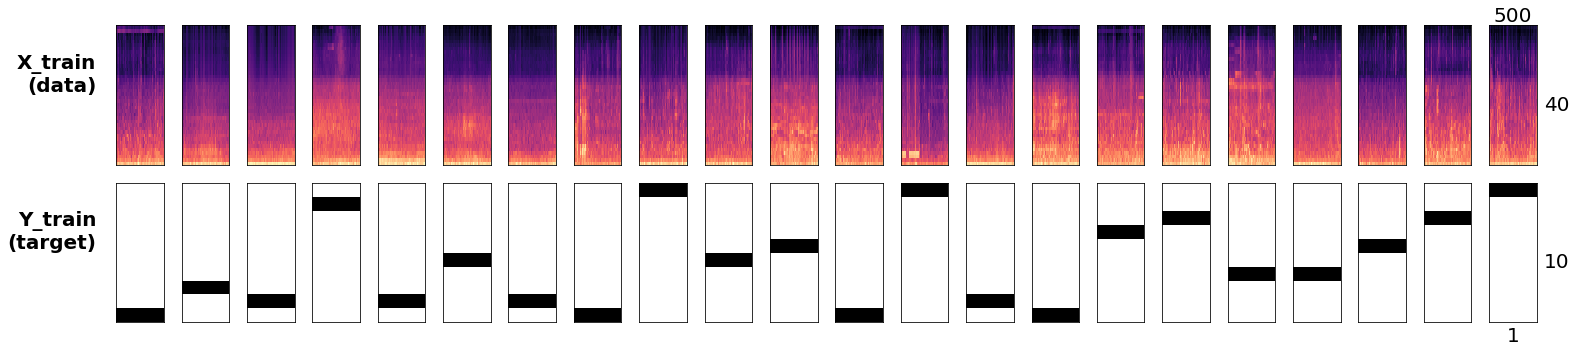

In [29]:
example_ids = numpy.random.choice(range(X_train.shape[0]), 22, replace=False)
fig, axes = plt.subplots(2, len(example_ids), figsize=(22, 5))
fig.subplots_adjust(top=1.0, bottom=0.0, right=1.0, hspace=0.00, wspace=0.00)
for i, id in enumerate(example_ids):
    current_x = X_train[id,:,:]
    current_y = Y_train[id,:]
        
    plt.sca(axes[0, i])
    dcase_util.containers.FeatureContainer(current_x).plot(plot=False)
    
    plt.sca(axes[1, i])
    dcase_util.containers.BinaryMatrix2DContainer(numpy.expand_dims(current_y,-1)).plot(plot=False)
    
axes[0, -1].yaxis.set_label_position("right")
axes[0, -1].xaxis.set_label_position("top")
axes[0, -1].set_ylabel('40', rotation=0, fontsize=20, labelpad=20)
axes[0, -1].set_xlabel('500',fontsize=20)

axes[1, -1].yaxis.set_label_position("right")
axes[1, -1].xaxis.set_label_position("bottom")
axes[1, -1].set_ylabel('10', rotation=0, fontsize=20, labelpad=20)
axes[1, -1].set_xlabel('1',fontsize=20)

axes[0, 0].set_ylabel('X_train\n(data)', rotation=0, fontsize=20, labelpad=20, fontweight='bold', ha='right')
axes[1, 0].yaxis.set_label_position("left")
axes[1, 0].set_ylabel('Y_train\n(target)', rotation=0, fontsize=20, labelpad=20, fontweight='bold', ha='right')    

plt.tight_layout()

# Neural network structure

Next we create neural network structure layer by layer.


**Input** layer:

In [101]:
feature_vector_length = mel_extractor.n_mels   # Number of mel bands

In [102]:
input_layer = Input(
    shape=(feature_vector_length, sequence_length), 
    name='Input'
)

**Reshaping** layer to add channel axis into input data:

In [103]:
x = Reshape(
    target_shape=(feature_vector_length, sequence_length, 1), 
    name='Input_Reshape'
)(input_layer)

In [104]:
print('Output shape','(sequence, frequency, time, channel)', x._keras_shape)

Output shape (sequence, frequency, time, channel) (None, 40, 500, 1)


Two convolutional **layer groups** consisting of:

1) **Convolution** to capture context and to extract high-level features: <br>*kernel 5x5 and filters 64*

In [105]:
x = Conv2D(
    filters=64, 
    kernel_size=(5, 5), 
    activation='linear', 
    padding='same', 
    data_format='channels_last',
    name='Conv1'
)(x)

2) **Batch normalization** to enable higher learning rates

In [106]:
x = BatchNormalization(
    axis=-1, 
    name='Conv1_BatchNorm'
)(x)

3) **Activation** (ReLu) to introduce non-linearity

In [107]:
x = Activation(
    activation='relu', name='Conv1_Activation'
)(x)

4) **Pooling** (2D) to extract dominant features<br>*pooling along both time and frequency*

In [108]:
x = MaxPooling2D(
    pool_size=(2, 4), name='Conv1_Pooling'
)(x)

5) **Dropout** to avoid overfitting

In [109]:
x = Dropout(
    rate=0.2, name='Conv1_DropOut'
)(x)

In [110]:
print('Output shape of CNN group 1','(sequence, frequency, time, feature)', x._keras_shape)

Output shape of CNN group 1 (sequence, frequency, time, feature) (None, 20, 125, 64)


Second convolutional layer:

In [111]:
x = Conv2D(filters=64, kernel_size=(5, 5), activation='linear', padding='same', data_format='channels_last', name='Conv2')(x)
x = BatchNormalization(axis=-1, name='Conv2_BatchNorm')(x)
x = Activation(activation='relu', name='Conv2_Activation')(x)
x = MaxPooling2D(pool_size=(2, 2), name='Conv2_Pooling')(x)
x = Dropout(rate=0.2, name='Conv2_DropOut')(x)

In [112]:
print('Output shape of CNN group 2','(sequence, frequency, time, feature)', x._keras_shape)

Output shape of CNN group 2 (sequence, frequency, time, feature) (None, 10, 62, 64)


**Global max pooling** is applied to output of the last convolutional layer group to summarize output into a **single vector**:

In [113]:
x = GlobalMaxPooling2D(
    data_format='channels_last', 
    name='GlobalPooling'
)(x)


In [114]:
print('Output shape','(sequence, feature)', x._keras_shape)

Output shape (sequence, feature) (None, 64)


**Output layer** as fully-connected layer with a softmax activation:

In [115]:
output_layer = Dense(
    units=len(db.scene_labels()), 
    activation='softmax', 
    name='Output'
)(x)


In [116]:
print('Output shape','(sequence, class)', output_layer._keras_shape)

Output shape (sequence, class) (None, 10)


Create a model network:

In [117]:
model = Model(inputs=input_layer, outputs=output_layer)

## Model summary

In [100]:
dcase_util.keras.model_summary_string(
    keras_model=model,
    mode='extended', 
    show_parameters=False, 
    display=True
) # alternative for print(model.summary()) to get html table

Layer name,Layer type,Output shape,Parameters
Input,InputLayer,"(None, 40, 500)",0
Input_Reshape,Reshape,"(None, 40, 500, 1)",0
Conv1,Conv2D,"(None, 40, 500, 64)",1664
Conv1_BatchNorm,BatchNorm,"(None, 40, 500, 64)",256
Conv1_Activation,Activation,"(None, 40, 500, 64)",0
Conv1_Pooling,MaxPooling2D,"(None, 20, 125, 64)",0
Conv1_DropOut,Dropout,"(None, 20, 125, 64)",0
Conv2,Conv2D,"(None, 20, 125, 64)",102464
Conv2_BatchNorm,BatchNorm,"(None, 20, 125, 64)",256
Conv2_Activation,Activation,"(None, 20, 125, 64)",0


## Training

Key parameters:

- **Loss** &ndash; function used to measure difference between target and prediction <br> `categorical_crossentropy`
- **Metric** &ndash; evaluated for training and validation data during the learning process<br> `categorical_accuracy`
- **Optimizer** &ndash; function used to update model to minimize the loss
- **Learning rate** &ndash; how much model parameters are updated at each step
- **Batch size** &ndash; how many learning examples are processed before updating model parameters
- **Epochs** &ndash; how many times all learning data is gone through during the trainig procedure

In [34]:
callback_list=[
    dcase_util.keras.ProgressLoggerCallback(
        epochs=100, 
        metric='categorical_accuracy', 
        loss='categorical_crossentropy', 
        output_type='console', 
        show_timing=False,
    ),
    dcase_util.keras.StasherCallback(
        epochs=100, 
        monitor='val_categorical_accuracy'
    )
]

Compile the model:

In [35]:
model.compile(
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
    optimizer=keras.optimizers.Adam(lr=0.001, decay=0.001)
)

Start learning process:

In [36]:
history = model.fit(
    x=X_train, y=Y_train,
    validation_data=(X_validation, Y_validation),
    callbacks=callback_list,
    verbose=0,
    epochs=100,
    batch_size=16
)

  Training
            Loss                                Metric                             
            categorical_crossentropy            categorical_accuracy               
  Epoch     Train             Val               Train             Val              
  -------   ---------------   ---------------   ---------------   ---------------  
  1         1.4551            4.1296            0.4652            0.1474           
  2         1.3184            3.4960            0.5123            0.1469           
  3         1.2177            1.3006            0.5462            0.5307           
  4         1.1497            1.7890            0.5728            0.3556           
  5         1.0979            2.6919            0.6006            0.2862           
  6         1.0540            2.0941            0.6127            0.2254           
  7         1.0148            1.3386            0.6367            0.4864           
  8         0.9828            1.1452            0.6483           

## Best performing model

Best performing model was stored during the training process in `StasherCallback`:

In [37]:
for callback in callback_list:
    if isinstance(callback, dcase_util.keras.StasherCallback):                
        model.set_weights(callback.get_best()['weights'])       # Fetch the best performing model        
        callback.show()                                         # Show information
        break

Save model and training history:

In [38]:
# Save model
model.save(model_filename)

# Save training history
dcase_util.files.Serializer().save_cpickle(filename=os.path.join(data_storage_path, 'model_asc_training_history.cpickle'), data=history.history)

## Training history

In [3]:
hist = dcase_util.files.Serializer().load_cpickle(filename=os.path.join(data_storage_path, 'model_asc_training_history.cpickle'))

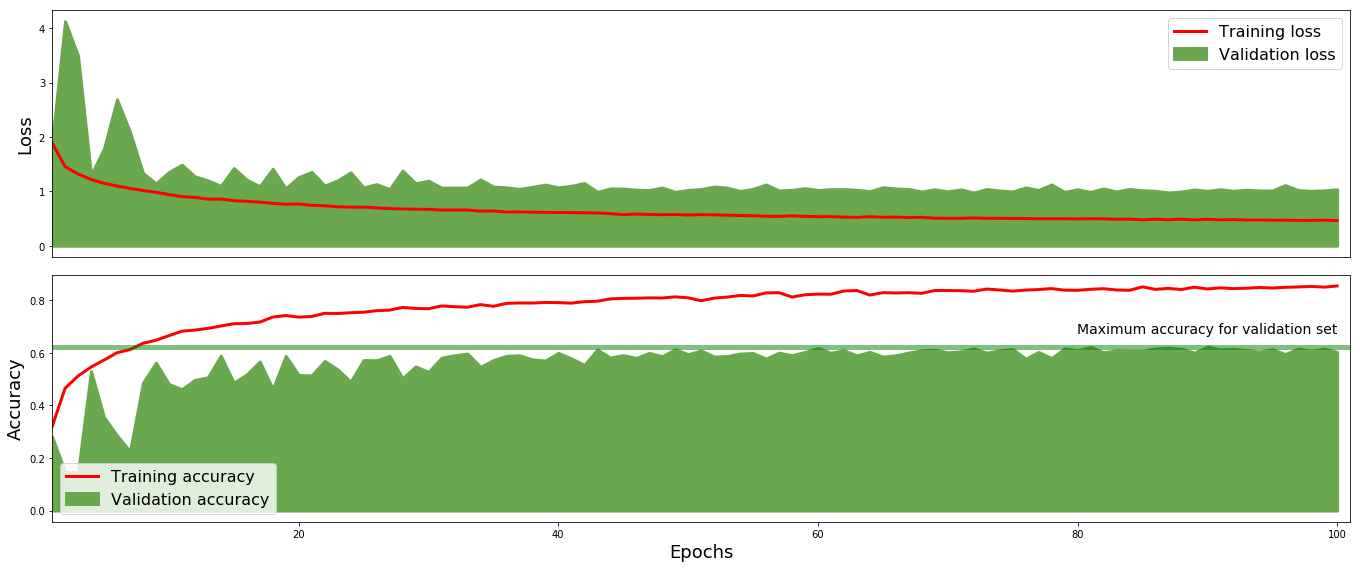

In [13]:
epochs = range(1, len(hist['loss']) + 1)
fig = plt.figure(figsize=(19,8))
plt.subplot(2,1,1)
plt.plot(epochs, hist['loss'], color='red', linewidth=3, label='Training loss')
#plt.plot(epochs, hist['val_loss'], color='green', linewidth=3, label='Validation loss')
plt.fill_between(epochs, numpy.squeeze(numpy.array(hist['val_loss'])), color='#6aa84f', linewidth=3, label='Validation loss')
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='best', fontsize=16)
panel = plt.gca()
panel.get_xaxis().set_visible(False)
panel.set_xlim([1,len(hist['loss']) + 1])

plt.subplot(2,1,2)
plt.plot(epochs, hist['categorical_accuracy'], color='red', linewidth=3, label='Training accuracy')
#plt.plot(epochs, hist['val_categorical_accuracy'], color='green', linewidth=3, label='Validation accuracy')
plt.fill_between(epochs, numpy.squeeze(numpy.array(hist['val_categorical_accuracy'])), color='#6aa84f', linewidth=3, label='Validation accuracy')

acc_min_index = numpy.argmax(hist['val_categorical_accuracy'])
plt.axhline(hist['val_categorical_accuracy'][acc_min_index], color='green', linestyle='-', linewidth=5, alpha=0.5)
plt.annotate('Maximum accuracy for validation set', xy=(len(hist['loss']),hist['val_categorical_accuracy'][acc_min_index]+0.05), fontsize=14, ha='right')
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])

plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()
plt.show()

# Testing stage

In [38]:
model = keras.models.load_model(model_filename) # Load model

**Extract** features for test item:

In [42]:
item = db.test(fold=1)[0]
features = mel_extractor.extract(
    AudioContainer().load(filename=item.filename, mono=True)
)[:,:sequence_length]

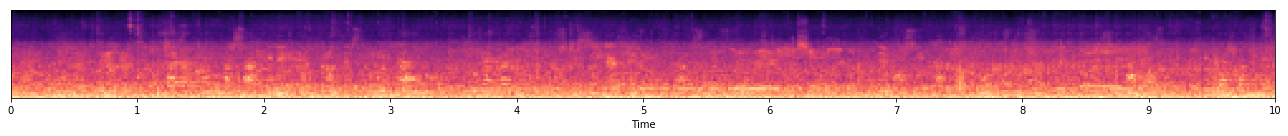

In [43]:
dcase_util.containers.FeatureContainer(features, time_resolution=0.02).plot(figsize=(18,2))

**Reshape** the matrix to match model input:

In [44]:
input_data = numpy.expand_dims(features, 0)

In [45]:
print('input_data shape', '(sequence, frequency, time)', input_data.shape)

input_data shape (sequence, frequency, time) (1, 40, 500)


Feed input data into model to get **probabilities for each scene class**:

In [46]:
probabilities = model.predict(x=input_data)
probabilities

array([[7.9669255e-01, 1.1163409e-03, 5.5917713e-04, 1.9114263e-02,
        1.0737061e-04, 5.2536655e-02, 4.5423049e-02, 7.8112699e-02,
        1.9047990e-04, 6.1474713e-03]], dtype=float32)

**Classify** by selecting class giving **maximum output**:

In [47]:
frame_decisions = dcase_util.data.ProbabilityEncoder().binarization(
    probabilities=probabilities.T,
    binarization_type='frame_max'
).T  
frame_decisions

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Scene label:

In [48]:
scene_labels[numpy.argmax(frame_decisions)]


'airport'

## Going through all test material

In [39]:
res = dcase_util.containers.MetaDataContainer(filename=os.path.join(data_storage_path, 'results_asc.csv'))

for item in db.test(fold=1):
    print('Test', db.absolute_to_relative_path(item.filename))
    # Load features
    features = get_feature_matrix(item.filename)[:,:sequence_length]
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename, mono=True)
    #)[:,:sequence_length]
    input_data = numpy.expand_dims(features, 0)

    # Get network output
    probabilities = model.predict(x=input_data)

    # Binarization and getting estimated scene label
    frame_decisions = dcase_util.data.ProbabilityEncoder().binarization(
        probabilities=probabilities.T,
        binarization_type='frame_max'
    )   
    estimated_scene_label = scene_labels[numpy.argmax(frame_decisions)]
    
    # Store result into results container
    res.append(
        {
            'filename': db.absolute_to_relative_path(item.filename),
            'scene_label': estimated_scene_label
        }
    )
    
# Save results container
res.save().show(mode='print')

Test audio/airport-barcelona-203-6122-a.wav
Test audio/airport-barcelona-203-6123-a.wav
Test audio/airport-barcelona-203-6124-a.wav
Test audio/airport-barcelona-203-6125-a.wav
Test audio/airport-barcelona-203-6126-a.wav
Test audio/airport-barcelona-203-6127-a.wav
Test audio/airport-barcelona-203-6128-a.wav
Test audio/airport-barcelona-203-6129-a.wav
Test audio/airport-barcelona-203-6130-a.wav
Test audio/airport-barcelona-203-6131-a.wav
Test audio/airport-barcelona-203-6132-a.wav
Test audio/airport-barcelona-203-6133-a.wav
Test audio/airport-barcelona-203-6134-a.wav
Test audio/airport-barcelona-203-6135-a.wav
Test audio/airport-barcelona-203-6136-a.wav
Test audio/airport-barcelona-203-6137-a.wav
Test audio/airport-helsinki-204-6138-a.wav
Test audio/airport-helsinki-204-6139-a.wav
Test audio/airport-helsinki-204-6140-a.wav
Test audio/airport-helsinki-204-6141-a.wav
Test audio/airport-helsinki-204-6142-a.wav
Test audio/airport-helsinki-204-6143-a.wav
Test audio/airport-helsinki-204-6144-a

Test audio/airport-stockholm-208-6319-a.wav
Test audio/airport-stockholm-208-6320-a.wav
Test audio/airport-stockholm-208-6321-a.wav
Test audio/airport-stockholm-208-6322-a.wav
Test audio/airport-stockholm-208-6323-a.wav
Test audio/airport-stockholm-208-6324-a.wav
Test audio/airport-stockholm-208-6325-a.wav
Test audio/airport-stockholm-208-6326-a.wav
Test audio/airport-stockholm-208-6327-a.wav
Test audio/airport-stockholm-208-6328-a.wav
Test audio/airport-stockholm-208-6329-a.wav
Test audio/airport-stockholm-208-6330-a.wav
Test audio/airport-stockholm-208-6331-a.wav
Test audio/airport-stockholm-208-6332-a.wav
Test audio/airport-stockholm-208-6333-a.wav
Test audio/airport-stockholm-208-6334-a.wav
Test audio/airport-stockholm-208-6335-a.wav
Test audio/airport-stockholm-208-6336-a.wav
Test audio/airport-stockholm-208-6337-a.wav
Test audio/airport-stockholm-208-6338-a.wav
Test audio/airport-stockholm-208-6339-a.wav
Test audio/airport-stockholm-208-6340-a.wav
Test audio/airport-stockholm-208

Test audio/bus-paris-215-6528-a.wav
Test audio/bus-paris-215-6529-a.wav
Test audio/bus-paris-215-6530-a.wav
Test audio/bus-paris-215-6531-a.wav
Test audio/bus-paris-215-6532-a.wav
Test audio/bus-paris-216-6533-a.wav
Test audio/bus-paris-216-6534-a.wav
Test audio/bus-paris-216-6535-a.wav
Test audio/bus-paris-216-6536-a.wav
Test audio/bus-paris-216-6537-a.wav
Test audio/bus-paris-216-6538-a.wav
Test audio/bus-paris-216-6539-a.wav
Test audio/bus-paris-216-6540-a.wav
Test audio/bus-paris-216-6541-a.wav
Test audio/bus-paris-216-6542-a.wav
Test audio/bus-paris-216-6543-a.wav
Test audio/bus-paris-216-6544-a.wav
Test audio/bus-stockholm-217-6545-a.wav
Test audio/bus-stockholm-217-6546-a.wav
Test audio/bus-stockholm-217-6547-a.wav
Test audio/bus-stockholm-217-6548-a.wav
Test audio/bus-stockholm-217-6549-a.wav
Test audio/bus-stockholm-217-6550-a.wav
Test audio/bus-stockholm-217-6551-a.wav
Test audio/bus-stockholm-217-6552-a.wav
Test audio/bus-stockholm-217-6553-a.wav
Test audio/bus-stockholm-217

Test audio/metro-helsinki-222-6737-a.wav
Test audio/metro-helsinki-222-6738-a.wav
Test audio/metro-helsinki-222-6739-a.wav
Test audio/metro-helsinki-222-6740-a.wav
Test audio/metro-helsinki-222-6741-a.wav
Test audio/metro-helsinki-222-6742-a.wav
Test audio/metro-helsinki-222-6743-a.wav
Test audio/metro-helsinki-222-6744-a.wav
Test audio/metro-helsinki-222-6745-a.wav
Test audio/metro-helsinki-222-6746-a.wav
Test audio/metro-helsinki-222-6747-a.wav
Test audio/metro-helsinki-222-6748-a.wav
Test audio/metro-helsinki-222-6749-a.wav
Test audio/metro-helsinki-222-6750-a.wav
Test audio/metro-helsinki-222-6751-a.wav
Test audio/metro-helsinki-222-6752-a.wav
Test audio/metro-helsinki-222-6753-a.wav
Test audio/metro-helsinki-222-6754-a.wav
Test audio/metro-helsinki-222-6755-a.wav
Test audio/metro-helsinki-222-6756-a.wav
Test audio/metro-helsinki-222-6757-a.wav
Test audio/metro-helsinki-222-6758-a.wav
Test audio/metro-helsinki-222-6759-a.wav
Test audio/metro-helsinki-222-6760-a.wav
Test audio/metro

Test audio/metro_station-barcelona-230-6933-a.wav
Test audio/metro_station-barcelona-230-6934-a.wav
Test audio/metro_station-barcelona-230-6935-a.wav
Test audio/metro_station-barcelona-230-6936-a.wav
Test audio/metro_station-barcelona-230-6937-a.wav
Test audio/metro_station-barcelona-230-6938-a.wav
Test audio/metro_station-barcelona-230-6939-a.wav
Test audio/metro_station-barcelona-230-6940-a.wav
Test audio/metro_station-barcelona-230-6941-a.wav
Test audio/metro_station-barcelona-230-6942-a.wav
Test audio/metro_station-barcelona-230-6943-a.wav
Test audio/metro_station-barcelona-230-6944-a.wav
Test audio/metro_station-barcelona-230-6945-a.wav
Test audio/metro_station-barcelona-230-6946-a.wav
Test audio/metro_station-barcelona-230-6947-a.wav
Test audio/metro_station-helsinki-231-6948-a.wav
Test audio/metro_station-helsinki-231-6949-a.wav
Test audio/metro_station-helsinki-231-6950-a.wav
Test audio/metro_station-helsinki-231-6951-a.wav
Test audio/metro_station-helsinki-231-6952-a.wav
Test 

Test audio/metro_station-stockholm-239-7104-a.wav
Test audio/metro_station-stockholm-239-7105-a.wav
Test audio/metro_station-stockholm-239-7106-a.wav
Test audio/metro_station-stockholm-239-7107-a.wav
Test audio/metro_station-stockholm-239-7108-a.wav
Test audio/metro_station-stockholm-239-7109-a.wav
Test audio/metro_station-stockholm-239-7110-a.wav
Test audio/metro_station-stockholm-239-7111-a.wav
Test audio/metro_station-stockholm-239-7112-a.wav
Test audio/metro_station-vienna-240-7113-a.wav
Test audio/metro_station-vienna-240-7114-a.wav
Test audio/metro_station-vienna-240-7115-a.wav
Test audio/metro_station-vienna-240-7116-a.wav
Test audio/metro_station-vienna-240-7117-a.wav
Test audio/metro_station-vienna-240-7118-a.wav
Test audio/metro_station-vienna-240-7119-a.wav
Test audio/metro_station-vienna-240-7120-a.wav
Test audio/metro_station-vienna-240-7121-a.wav
Test audio/metro_station-vienna-240-7122-a.wav
Test audio/metro_station-vienna-240-7123-a.wav
Test audio/metro_station-vienna-2

Test audio/park-stockholm-245-7306-a.wav
Test audio/park-stockholm-245-7307-a.wav
Test audio/park-stockholm-245-7308-a.wav
Test audio/park-stockholm-245-7309-a.wav
Test audio/park-stockholm-245-7310-a.wav
Test audio/park-stockholm-245-7311-a.wav
Test audio/park-stockholm-245-7312-a.wav
Test audio/park-stockholm-245-7313-a.wav
Test audio/park-stockholm-245-7314-a.wav
Test audio/park-stockholm-245-7315-a.wav
Test audio/park-stockholm-245-7316-a.wav
Test audio/park-stockholm-245-7317-a.wav
Test audio/park-stockholm-245-7318-a.wav
Test audio/park-stockholm-245-7319-a.wav
Test audio/park-stockholm-245-7320-a.wav
Test audio/park-stockholm-245-7321-a.wav
Test audio/park-stockholm-245-7322-a.wav
Test audio/park-stockholm-245-7323-a.wav
Test audio/park-stockholm-245-7324-a.wav
Test audio/park-stockholm-245-7325-a.wav
Test audio/park-stockholm-245-7326-a.wav
Test audio/park-stockholm-246-7327-a.wav
Test audio/park-stockholm-246-7328-a.wav
Test audio/park-stockholm-246-7329-a.wav
Test audio/park-

Test audio/public_square-london-250-7493-a.wav
Test audio/public_square-london-250-7494-a.wav
Test audio/public_square-london-250-7495-a.wav
Test audio/public_square-london-250-7496-a.wav
Test audio/public_square-london-250-7497-a.wav
Test audio/public_square-london-250-7498-a.wav
Test audio/public_square-paris-251-7499-a.wav
Test audio/public_square-paris-251-7500-a.wav
Test audio/public_square-paris-251-7501-a.wav
Test audio/public_square-paris-251-7502-a.wav
Test audio/public_square-paris-251-7503-a.wav
Test audio/public_square-paris-251-7504-a.wav
Test audio/public_square-paris-251-7505-a.wav
Test audio/public_square-paris-251-7506-a.wav
Test audio/public_square-paris-251-7507-a.wav
Test audio/public_square-paris-251-7508-a.wav
Test audio/public_square-paris-251-7509-a.wav
Test audio/public_square-paris-251-7510-a.wav
Test audio/public_square-paris-251-7511-a.wav
Test audio/public_square-paris-251-7512-a.wav
Test audio/public_square-paris-251-7513-a.wav
Test audio/public_square-par

Test audio/shopping_mall-helsinki-255-7663-a.wav
Test audio/shopping_mall-helsinki-255-7664-a.wav
Test audio/shopping_mall-helsinki-255-7665-a.wav
Test audio/shopping_mall-helsinki-255-7666-a.wav
Test audio/shopping_mall-helsinki-255-7667-a.wav
Test audio/shopping_mall-helsinki-255-7668-a.wav
Test audio/shopping_mall-helsinki-255-7669-a.wav
Test audio/shopping_mall-helsinki-255-7670-a.wav
Test audio/shopping_mall-helsinki-255-7671-a.wav
Test audio/shopping_mall-helsinki-255-7672-a.wav
Test audio/shopping_mall-helsinki-255-7673-a.wav
Test audio/shopping_mall-helsinki-255-7674-a.wav
Test audio/shopping_mall-helsinki-255-7675-a.wav
Test audio/shopping_mall-helsinki-255-7676-a.wav
Test audio/shopping_mall-helsinki-255-7677-a.wav
Test audio/shopping_mall-helsinki-255-7678-a.wav
Test audio/shopping_mall-london-256-7679-a.wav
Test audio/shopping_mall-london-256-7680-a.wav
Test audio/shopping_mall-london-256-7681-a.wav
Test audio/shopping_mall-london-256-7682-a.wav
Test audio/shopping_mall-lon

Test audio/shopping_mall-stockholm-258-7836-a.wav
Test audio/shopping_mall-stockholm-258-7837-a.wav
Test audio/shopping_mall-stockholm-258-7838-a.wav
Test audio/shopping_mall-stockholm-258-7839-a.wav
Test audio/shopping_mall-stockholm-258-7840-a.wav
Test audio/shopping_mall-stockholm-258-7841-a.wav
Test audio/shopping_mall-stockholm-258-7842-a.wav
Test audio/shopping_mall-stockholm-258-7843-a.wav
Test audio/shopping_mall-stockholm-258-7844-a.wav
Test audio/shopping_mall-stockholm-258-7845-a.wav
Test audio/shopping_mall-stockholm-258-7846-a.wav
Test audio/shopping_mall-stockholm-258-7847-a.wav
Test audio/shopping_mall-stockholm-258-7848-a.wav
Test audio/shopping_mall-stockholm-258-7849-a.wav
Test audio/shopping_mall-vienna-259-7850-a.wav
Test audio/shopping_mall-vienna-259-7851-a.wav
Test audio/shopping_mall-vienna-259-7852-a.wav
Test audio/shopping_mall-vienna-259-7853-a.wav
Test audio/shopping_mall-vienna-259-7854-a.wav
Test audio/shopping_mall-vienna-259-7855-a.wav
Test audio/shoppin

Test audio/street_pedestrian-london-263-7998-a.wav
Test audio/street_pedestrian-paris-264-7999-a.wav
Test audio/street_pedestrian-paris-264-8000-a.wav
Test audio/street_pedestrian-paris-264-8001-a.wav
Test audio/street_pedestrian-paris-264-8002-a.wav
Test audio/street_pedestrian-paris-264-8003-a.wav
Test audio/street_pedestrian-paris-264-8004-a.wav
Test audio/street_pedestrian-paris-264-8005-a.wav
Test audio/street_pedestrian-paris-264-8006-a.wav
Test audio/street_pedestrian-paris-264-8007-a.wav
Test audio/street_pedestrian-paris-264-8008-a.wav
Test audio/street_pedestrian-paris-264-8009-a.wav
Test audio/street_pedestrian-paris-264-8010-a.wav
Test audio/street_pedestrian-paris-264-8011-a.wav
Test audio/street_pedestrian-paris-264-8012-a.wav
Test audio/street_pedestrian-paris-264-8013-a.wav
Test audio/street_pedestrian-paris-264-8014-a.wav
Test audio/street_pedestrian-paris-264-8015-a.wav
Test audio/street_pedestrian-paris-264-8016-a.wav
Test audio/street_pedestrian-paris-264-8017-a.wav

Test audio/street_traffic-barcelona-268-8159-a.wav
Test audio/street_traffic-barcelona-268-8160-a.wav
Test audio/street_traffic-barcelona-268-8161-a.wav
Test audio/street_traffic-barcelona-268-8162-a.wav
Test audio/street_traffic-barcelona-268-8163-a.wav
Test audio/street_traffic-barcelona-268-8164-a.wav
Test audio/street_traffic-barcelona-268-8165-a.wav
Test audio/street_traffic-barcelona-268-8166-a.wav
Test audio/street_traffic-barcelona-268-8167-a.wav
Test audio/street_traffic-barcelona-268-8168-a.wav
Test audio/street_traffic-helsinki-269-8169-a.wav
Test audio/street_traffic-helsinki-269-8170-a.wav
Test audio/street_traffic-helsinki-269-8171-a.wav
Test audio/street_traffic-helsinki-269-8172-a.wav
Test audio/street_traffic-helsinki-269-8173-a.wav
Test audio/street_traffic-helsinki-269-8174-a.wav
Test audio/street_traffic-helsinki-269-8175-a.wav
Test audio/street_traffic-helsinki-269-8176-a.wav
Test audio/street_traffic-helsinki-269-8177-a.wav
Test audio/street_traffic-helsinki-269-8

Test audio/street_traffic-stockholm-273-8328-a.wav
Test audio/street_traffic-stockholm-273-8329-a.wav
Test audio/street_traffic-stockholm-273-8330-a.wav
Test audio/street_traffic-stockholm-273-8331-a.wav
Test audio/street_traffic-stockholm-273-8332-a.wav
Test audio/street_traffic-stockholm-273-8333-a.wav
Test audio/street_traffic-stockholm-273-8334-a.wav
Test audio/street_traffic-stockholm-273-8335-a.wav
Test audio/street_traffic-stockholm-273-8336-a.wav
Test audio/street_traffic-stockholm-273-8337-a.wav
Test audio/street_traffic-stockholm-273-8338-a.wav
Test audio/street_traffic-stockholm-273-8339-a.wav
Test audio/street_traffic-stockholm-273-8340-a.wav
Test audio/street_traffic-stockholm-273-8341-a.wav
Test audio/street_traffic-stockholm-273-8342-a.wav
Test audio/street_traffic-vienna-274-8343-a.wav
Test audio/street_traffic-vienna-274-8344-a.wav
Test audio/street_traffic-vienna-274-8345-a.wav
Test audio/street_traffic-vienna-274-8346-a.wav
Test audio/street_traffic-vienna-274-8347-a

Test audio/tram-paris-282-8528-a.wav
Test audio/tram-paris-282-8529-a.wav
Test audio/tram-paris-282-8530-a.wav
Test audio/tram-paris-282-8531-a.wav
Test audio/tram-paris-282-8532-a.wav
Test audio/tram-paris-282-8533-a.wav
Test audio/tram-paris-282-8534-a.wav
Test audio/tram-paris-282-8535-a.wav
Test audio/tram-paris-282-8536-a.wav
Test audio/tram-paris-282-8537-a.wav
Test audio/tram-paris-282-8538-a.wav
Test audio/tram-paris-282-8539-a.wav
Test audio/tram-paris-282-8540-a.wav
Test audio/tram-paris-282-8541-a.wav
Test audio/tram-paris-282-8542-a.wav
Test audio/tram-paris-282-8543-a.wav
Test audio/tram-paris-282-8544-a.wav
Test audio/tram-paris-282-8545-a.wav
Test audio/tram-stockholm-283-8546-a.wav
Test audio/tram-stockholm-283-8547-a.wav
Test audio/tram-stockholm-283-8548-a.wav
Test audio/tram-stockholm-283-8549-a.wav
Test audio/tram-stockholm-283-8550-a.wav
Test audio/tram-stockholm-283-8551-a.wav
Test audio/tram-stockholm-283-8552-a.wav
Test audio/tram-stockholm-283-8553-a.wav
Test a

# Evaluation

## Preparing data for evaluation

In [30]:
# Load reference and system output
reference_scene_list = db.eval(fold=1)
estimated_scene_list = dcase_util.containers.MetaDataContainer(
    filename=os.path.join(data_storage_path, 'results_asc.csv')
).load()
# Collect test items into lists in same order
y_true = []
y_pred = []
for item_id, item in enumerate(reference_scene_list):
    y_true.append(item.scene_label)
    for item_estimated in estimated_scene_list:
        if os.path.split(item_estimated.filename)[-1] == os.path.split(item.filename)[-1]:
            y_pred.append(item_estimated.scene_label)
            break

## Calculating metric

In [31]:
# Get confusion matrix with counts
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

# Transform matrix into percentages, normalize row-wise
conf = confusion_matrix * 100.0 / confusion_matrix.sum(axis=1)[:, numpy.newaxis]  

# Fetch class-wise accuracies from diagonal
class_wise_accuracies = numpy.diag(conf)                

# Calculate overall accuracy
numpy.mean(class_wise_accuracies)


59.417502980063

## Class-wise accuracies

In [32]:
labels = db.scene_labels()
labels.append('Average')
values = class_wise_accuracies
values = numpy.append(values, numpy.mean(class_wise_accuracies))
log.table(
    cell_data=[
        labels,values
    ],
    column_headers=['Scene label', 'Accuracy'],
    column_types=['str30', 'float1'],
    row_separators=[10],
    scaling=120,
)

Scene label,Accuracy
airport,74.7
bus,65.3
metro,48.3
metro_station,54.4
park,82.6
public_square,48.6
shopping_mall,46.6
street_pedestrian,43.3
street_traffic,73.6
tram,56.7


## Confusion matrix

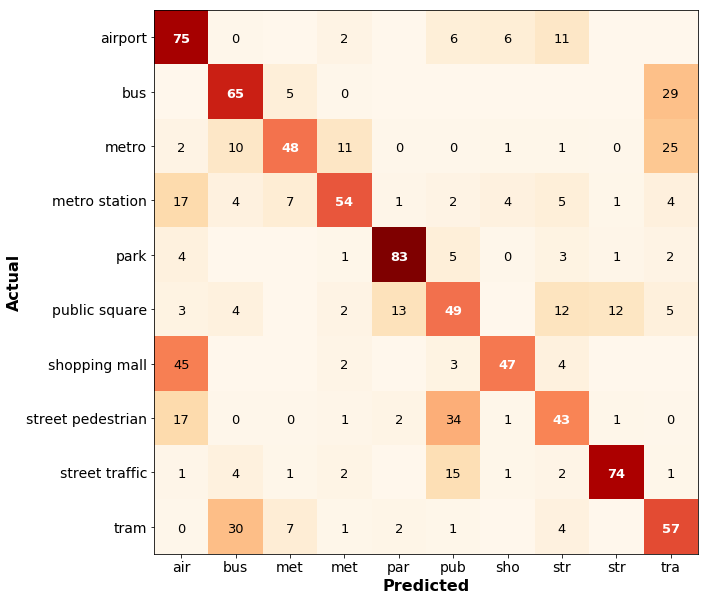

In [33]:
fig = plt.figure(figsize=(10,10))    
plt.imshow(conf, cmap=plt.cm.OrRd)
labels = []
labels_short = []
for label in db.scene_labels():
    labels.append(str(label.replace('_', ' ')))
    labels_short.append(label[0:3])    
plt.yticks(range(len(scene_labels)), labels, fontsize=14)
plt.xticks(range(len(scene_labels)), labels_short, fontsize=14)
plt.ylabel('Actual', fontsize=16, fontweight="bold")
plt.xlabel('Predicted', fontsize=16, fontweight="bold")
for x in range(len(scene_labels)):
    for y in range(len(scene_labels)):
        if conf[y, x] > 0:
            plt.text(x, y + 0.1, "{:.0f}".format(conf[y, x]), 
                     fontsize=13, ha='center', 
                     color= 'white' if (x==y) else 'black', 
                     weight= 'bold' if (x==y) else 'normal')          

## Confidence interval for the accuracy

In [36]:
from statsmodels.stats import proportion
Nref = len(y_true)
Ncorr = numpy.sum(numpy.diag(confusion_matrix))
ci95 = proportion.proportion_confint(
    count=Ncorr,
    nobs=Nref,
    alpha=0.05,
    method='normal'
)
print('95% confidence interval:', '{0:2.2f} - {1:2.2f}'.format(ci95[0]*100, ci95[1]*100))

95% confidence interval: 57.41 - 61.25
